# ML Options Pricing Model

### This notebook replicates the functionality of `main.py` while adding visualizations, statistical comparisons, and regression analysis.

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from scipy.interpolate import griddata

In [2]:
from data_loader import options_chain
from volatility_model import VolatilityModel
from pricing_model import PricingModel
from signal_generator import SignalGenerator

In [3]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

### Calculate historical volatility using GARCH

In [4]:
ticker = 'AAPL'

In [5]:
options, interest_rate, implied_volatility = options_chain(ticker)
stock_data = yf.download(ticker, period="5y")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
print("Options Chain:")
print(options.head())

Options Chain:
   strikePrice expirationDate putCall     bid     ask    mark  volatility  \
0          5.0     2025-10-18    CALL  228.65  231.95  230.30    7805.668   
1         10.0     2025-10-18    CALL  224.00  226.35  225.18    6305.749   
2         15.0     2025-10-18    CALL  218.80  221.90  220.35    5459.839   
3         20.0     2025-10-18    CALL  213.95  216.30  215.13    4871.802   
4         25.0     2025-10-18    CALL  208.50  211.00  209.75    4321.456   

   delta  gamma  theta  vega  rho  openInterest  timeValue  \
0    1.0    0.0   -0.0   0.0  0.0             0     -4.120   
1    1.0    0.0   -0.0   0.0  0.0             0      0.175   
2    1.0    0.0   -0.0   0.0  0.0             0    -15.200   
3    1.0    0.0   -0.0   0.0  0.0             0      0.125   
4    1.0    0.0   -0.0   0.0  0.0             0      0.075   

   theoreticalOptionValue  ImpliedVolatility  daysToExpiration  inTheMoney  
0                   230.0               29.0               125        Tr

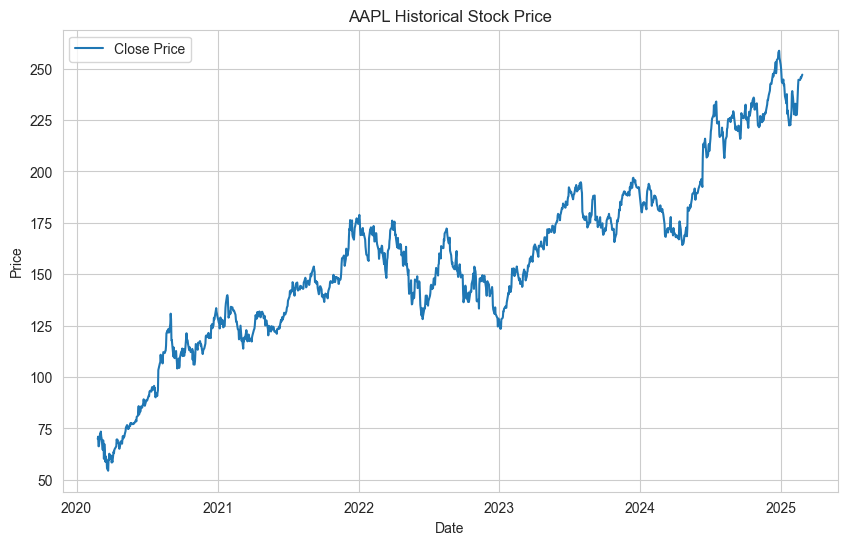

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Close'], label='Close Price')
plt.title(f"{ticker} Historical Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [8]:
stock_data['LogReturn'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
stock_data.dropna(inplace=True)

In [9]:
stock_data['LogReturn'] *= 100

In [10]:
garch_model = arch_model(stock_data['LogReturn'], vol='Garch', p=1, q=1)
garch_model_fit = garch_model.fit(disp='off')

In [11]:
print(garch_model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              LogReturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2493.26
Distribution:                  Normal   AIC:                           4994.53
Method:            Maximum Likelihood   BIC:                           5015.07
                                        No. Observations:                 1256
Date:                Tue, Feb 25 2025   Df Residuals:                     1255
Time:                        00:33:07   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1262  4.918e-02      2.567  1.027e-02 [2.984e-0

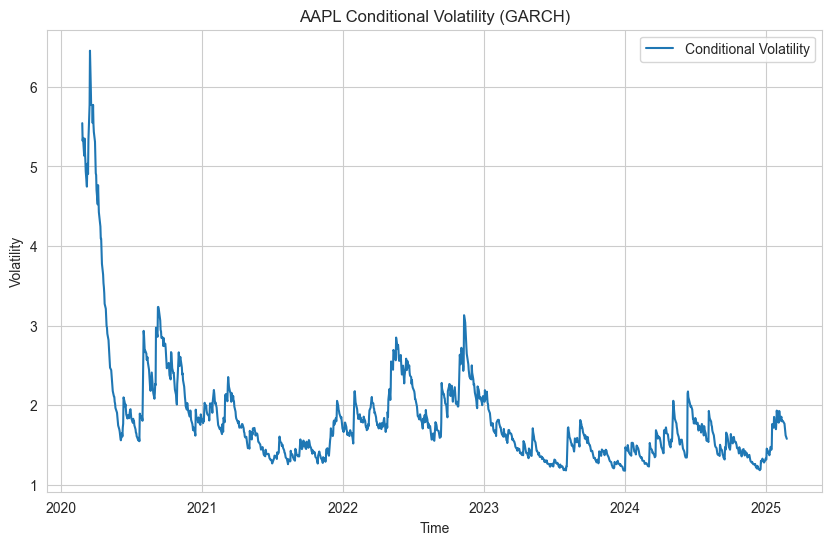

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(garch_model_fit.conditional_volatility, label='Conditional Volatility')
plt.title(f"{ticker} Conditional Volatility (GARCH)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [13]:
underlying_price = stock_data['Close'].iloc[-1]
risk_free_rate = interest_rate / 100

In [14]:
volModel = VolatilityModel(options_chain_df=options, underlying_price=underlying_price, risk_free_rate=risk_free_rate)
historical_volatility = garch_model_fit.conditional_volatility

In [15]:
options['ImpliedVolatility'] = options.apply(
    lambda row: volModel.calculate_implied_volatility(
        option_price=row['mark'],
        strike=row['strikePrice'],
        expiration_days=row['daysToExpiration'],
        option_type=row['putCall'],  # 'CALL' or 'PUT'
    ),
    axis=1
)

In [16]:
# Display the first few rows of the options chain with implied volatilities
print("Options Chain with Implied Volatilities:")
print(options.head())

Options Chain with Implied Volatilities:
   strikePrice expirationDate putCall     bid     ask    mark  volatility  \
0          5.0     2025-10-18    CALL  228.65  231.95  230.30    7805.668   
1         10.0     2025-10-18    CALL  224.00  226.35  225.18    6305.749   
2         15.0     2025-10-18    CALL  218.80  221.90  220.35    5459.839   
3         20.0     2025-10-18    CALL  213.95  216.30  215.13    4871.802   
4         25.0     2025-10-18    CALL  208.50  211.00  209.75    4321.456   

   delta  gamma  theta  vega  rho  openInterest  timeValue  \
0    1.0    0.0   -0.0   0.0  0.0             0     -4.120   
1    1.0    0.0   -0.0   0.0  0.0             0      0.175   
2    1.0    0.0   -0.0   0.0  0.0             0    -15.200   
3    1.0    0.0   -0.0   0.0  0.0             0      0.125   
4    1.0    0.0   -0.0   0.0  0.0             0      0.075   

   theoreticalOptionValue  ImpliedVolatility  daysToExpiration  inTheMoney  
0                   230.0                0.2  

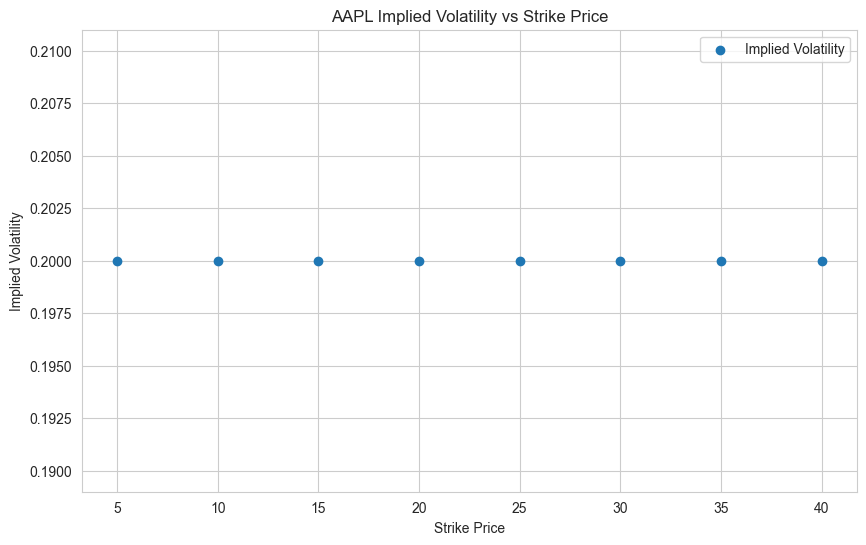

In [17]:
# Plot implied volatility vs strike price
plt.figure(figsize=(10, 6))
plt.scatter(options['strikePrice'], options['ImpliedVolatility'], label='Implied Volatility')
plt.title(f"{ticker} Implied Volatility vs Strike Price")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()

In [18]:
strikes = options['strikePrice'].values
expirations = options['daysToExpiration'].values
implied_vols = options['ImpliedVolatility'].values

In [19]:
grid_strikes, grid_expirations = np.meshgrid(
    np.linspace(strikes.min(), strikes.max(), 100),
    np.linspace(expirations.min(), expirations.max(), 100)
)

In [20]:
# Add small noise to strikes and expirations
noise_level = 1e-5  # Adjust this value as needed
strikes = options['strikePrice'].values + np.random.normal(0, noise_level, size=len(options))
expirations = options['daysToExpiration'].values + np.random.normal(0, noise_level, size=len(options))
implied_vols = options['ImpliedVolatility'].values

# Create a grid for interpolation
grid_strikes, grid_expirations = np.meshgrid(
    np.linspace(strikes.min(), strikes.max(), 100),
    np.linspace(expirations.min(), expirations.max(), 100)
)

# Interpolate using cubic spline
volatility_surface = griddata(
    (strikes, expirations), implied_vols,
    (grid_strikes, grid_expirations), method='cubic'
)

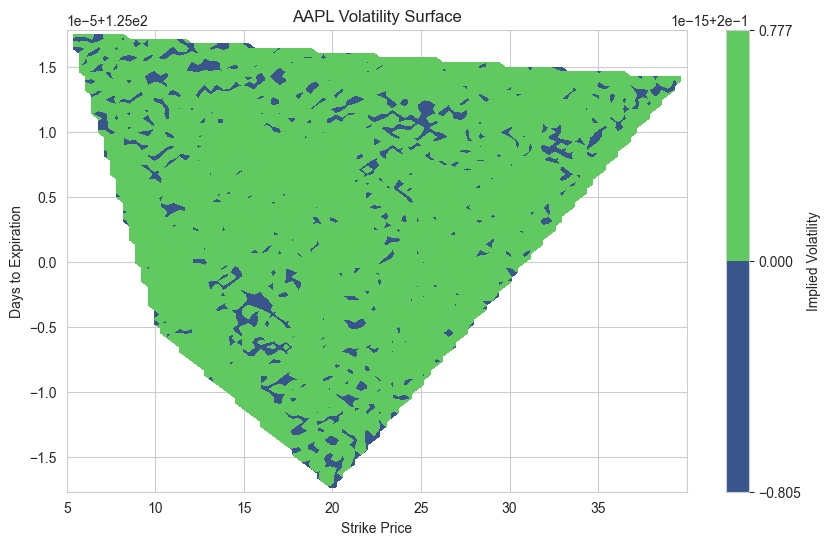

In [21]:
plt.figure(figsize=(10, 6))
plt.contourf(grid_strikes, grid_expirations, volatility_surface, levels=50, cmap='viridis')
plt.colorbar(label='Implied Volatility')
plt.title(f"{ticker} Volatility Surface")
plt.xlabel("Strike Price")
plt.ylabel("Days to Expiration")
plt.show()

In [22]:
underlying_price = stock_data['Close'].iloc[-1]
options['Moneyness'] = underlying_price[0] / options['strikePrice']
options['TimeToExpiration'] = options['daysToExpiration'] / 365
options['RiskFreeRate'] = interest_rate / 100
options['HistoricalVolatility'] = garch_model_fit.conditional_volatility[-1] / 100

In [23]:
print("Options Chain with Features:")
print(options.head())

Options Chain with Features:
   strikePrice expirationDate putCall     bid     ask    mark  volatility  \
0          5.0     2025-10-18    CALL  228.65  231.95  230.30    7805.668   
1         10.0     2025-10-18    CALL  224.00  226.35  225.18    6305.749   
2         15.0     2025-10-18    CALL  218.80  221.90  220.35    5459.839   
3         20.0     2025-10-18    CALL  213.95  216.30  215.13    4871.802   
4         25.0     2025-10-18    CALL  208.50  211.00  209.75    4321.456   

   delta  gamma  theta  ...  openInterest  timeValue  theoreticalOptionValue  \
0    1.0    0.0   -0.0  ...             0     -4.120                   230.0   
1    1.0    0.0   -0.0  ...             0      0.175                   225.0   
2    1.0    0.0   -0.0  ...             0    -15.200                   220.0   
3    1.0    0.0   -0.0  ...             0      0.125                   215.0   
4    1.0    0.0   -0.0  ...             0      0.075                   210.0   

   ImpliedVolatility  daysT

### Train the XGBoost model

In [24]:
pricing_model = PricingModel()
pricing_model.train_xgboost_model(options)

Validation Mean Squared Error: 8.881784130826803e-18


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
predicted_chain = pricing_model.predict_option_chain(
    stock_price=stock_data['Close'].iloc[-1],
    options_chain=options,
    interest_rate=interest_rate,
    historical_volatility=historical_volatility.iloc[-1]
)

In [26]:
print("Predicted Option Chain:")
print(predicted_chain.head())

Predicted Option Chain:
   strikePrice expirationDate putCall     bid     ask  \
0          5.0     2025-10-18    CALL  228.65  231.95   
1         10.0     2025-10-18    CALL  224.00  226.35   
2         15.0     2025-10-18    CALL  218.80  221.90   
3         20.0     2025-10-18    CALL  213.95  216.30   
4         25.0     2025-10-18    CALL  208.50  211.00   

                                                mark  volatility  delta  \
0  Ticker
AAPL    242.180482
Name: 2025-02-24 00:...         0.2    1.0   
1  Ticker
AAPL    237.260957
Name: 2025-02-24 00:...         0.2    1.0   
2  Ticker
AAPL    232.341433
Name: 2025-02-24 00:...         0.2    1.0   
3  Ticker
AAPL    227.421908
Name: 2025-02-24 00:...         0.2    1.0   
4  Ticker
AAPL    222.502383
Name: 2025-02-24 00:...         0.2    1.0   

                                               gamma  \
0  Ticker
AAPL    1.345425e-246
Name: 2025-02-24 ...   
1  Ticker
AAPL    5.382327e-168
Name: 2025-02-24 ...   
2  Ticker
AAPL

### Trading Signals

In [27]:
signal_generator = SignalGenerator(threshold=0.05)
signals = signal_generator.generate_trading_signals(predicted_chain)

In [28]:
print("\nTrading Signals:")
print(signal_generator.format_output(signals))


Trading Signals:
Option: CALL 5.0 Expiring on 2025-10-18
Market Price: $242.18, Predicted Price: $242.18, Difference: 0.00%
Signal: Hold
Greeks - Delta: 1.0000, Gamma: 0.0000, Theta: 0.0006, Vega: 0.0000, Rho: 0.0168
In The Money: True
--------------------------------------------------
Option: CALL 10.0 Expiring on 2025-10-18
Market Price: $237.26, Predicted Price: $237.26, Difference: 0.00%
Signal: Hold
Greeks - Delta: 1.0000, Gamma: 0.0000, Theta: 0.0013, Vega: 0.0000, Rho: 0.0337
In The Money: True
--------------------------------------------------
Option: CALL 15.0 Expiring on 2025-10-18
Market Price: $232.34, Predicted Price: $232.34, Difference: 0.00%
Signal: Hold
Greeks - Delta: 1.0000, Gamma: 0.0000, Theta: 0.0019, Vega: 0.0000, Rho: 0.0505
In The Money: True
--------------------------------------------------
Option: CALL 20.0 Expiring on 2025-10-18
Market Price: $227.42, Predicted Price: $227.42, Difference: 0.00%
Signal: Hold
Greeks - Delta: 1.0000, Gamma: 0.0000, Theta: 0.0

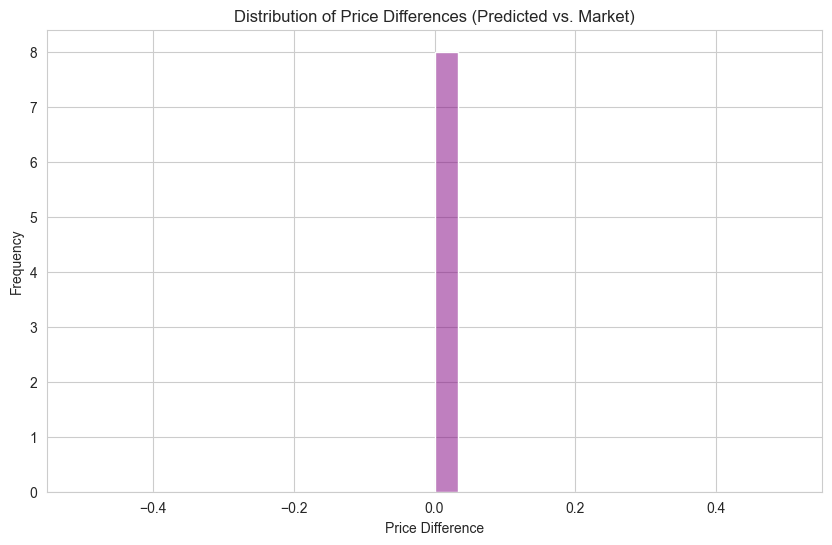

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(signals['priceDifference'], bins=30, kde=True, color="purple")
plt.title("Distribution of Price Differences (Predicted vs. Market)")
plt.xlabel("Price Difference")
plt.ylabel("Frequency")
plt.show()

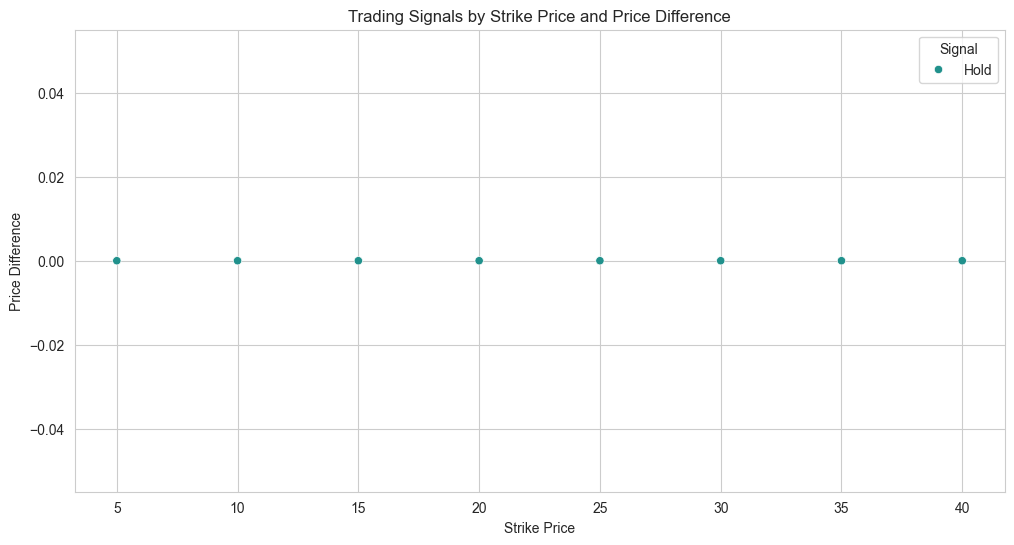

In [30]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x="strikePrice", y="priceDifference", hue="signal", data=signals, palette="viridis")
plt.title("Trading Signals by Strike Price and Price Difference")
plt.xlabel("Strike Price")
plt.ylabel("Price Difference")
plt.legend(title="Signal")
plt.show()